# Final Project - Trump/Hillary Tweets
### Question: 

What combination of words result in the highest amount of retweets? As in, are there a set of #N words that Trump or Hillary could tweet that garners the most retweets and likes?

We are using Trump and Hillary Tweets before the 2016 Presidential Election and analyzing these two datasets to find the most common words that each respective candidates used.

In [1]:
%matplotlib inline

#Basic packages to be used in the project. 
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import string

from pytagcloud import create_tag_image, make_tags
from pytagcloud.lang.counter import get_tag_counts
import matplotlib.image as mpimg
from IPython.display import Image


#Natural Language Toolkit
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords

#NLTK tokenizer for tweets.
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MKS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MKS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading and Cleaning the Data

We are loading both the datasets so we can retrieve both Trump and Hillary tweets.

In [2]:
#Dataframe of Trump tweets.
df_trump = pd.read_csv('Trump_Tweets.csv', encoding='latin-1');

#Dataframe of Hillary tweets.
df_th = pd.read_csv('Trump_Hillary_Tweets.csv');
df_hillary = df_th[df_th['handle'] == 'HillaryClinton'];

In [3]:
#Cleaned unnecessary columns of the Trump tweets.
del df_trump['Unnamed: 10'];
del df_trump['Unnamed: 11'];

In [4]:
#TESTING
#df_trump

In [5]:
#TESTING
#tweet = tknzr.tokenize(df_trump['Tweet_Text'][0])
#tweet = words_stop(tweet)
#tweet = words_only(tweet)
#tweet = words_extra(tweet)
#print(tweet);

## Data Manipulation

In [6]:
#Helper method to filter out stopwords.
def words_stop(tweet_list):
    punctuation = list(string.punctuation)
    stop = stopwords.words('english') + punctuation + ['rt','via']
    return [word for word in tweet_list if word not in stop]

#Helper method to filter out hashtags and mentions.
def words_only(tweet_list):
    return [word for word in tweet_list if not word.startswith(('#','@','û','https'))]

#Helper method to filter extra words.
def words_extra(tweet_list):
    extra = ['\x89','...','…','“','”','’','—']
    return [word for word in tweet_list if word not in extra]

### 1. Parsing the Trump Tweets.

We are parsing the Trump tweets, so we can create a frequency distribution of words contained in his tweets.

In [7]:
#METHOD: Parse Trump tweets and create a frequency distribution of words.

#Tokenizes the Trump tweets.
trump_list = []
for trump_tweets in df_trump['Tweet_Text']:
    trump_list.extend(tknzr.tokenize(trump_tweets))

#Filters the tweets.
trump_list = words_stop(trump_list)
trump_list = words_only(trump_list)
trump_list = words_extra(trump_list)

#Create the frequency distribution.
fdist_t = nltk.FreqDist(trump_list)

In [8]:
#print(fdist_t);
#trump_list

In [9]:
fdist_t.most_common(20)

[('trump', 1173),
 ('great', 1045),
 ('thank', 889),
 ('hillary', 543),
 ('america', 487),
 ('people', 443),
 ('new', 410),
 ('poll', 364),
 ('make', 346),
 ('donald', 321),
 ('clinton', 316),
 ('get', 305),
 ('president', 267),
 ('like', 266),
 ('big', 263),
 ('vote', 257),
 ('tonight', 244),
 ('time', 232),
 ('cruz', 228),
 ('one', 227)]

### 2. Parsing the Hillary Tweets.

We are parsing the Hillary tweets, so we can create a frequency distribution of words contained in her tweets.

In [10]:
#Tokenizes the Hillary tweets.
hillary_list = []
for hillary_tweets in df_hillary['text']:
    hillary_list.extend(tknzr.tokenize(hillary_tweets))

#Filters the tweets.
hillary_list = words_stop(hillary_list)
hillary_list = words_only(hillary_list)
hillary_list = words_extra(hillary_list)

#Create the frequency distribution.
fdist_h = nltk.FreqDist(hillary_list)

In [11]:
#print(fdist);
#hillary_list

In [12]:
fdist_h.most_common(20)

[('trump', 774),
 ('hillary', 708),
 ('donald', 427),
 ('president', 279),
 ('america', 203),
 ('people', 195),
 ('make', 189),
 ('one', 181),
 ('us', 174),
 ("trump's", 149),
 ('families', 143),
 ('need', 130),
 ('americans', 129),
 ('women', 126),
 ('would', 122),
 ('clinton', 120),
 ('country', 119),
 ("it's", 117),
 ('like', 114),
 ('together', 111)]

### 3. Dictionary of words with favourites and retweets.

Create a dictionary with the words as the key and a tuple of retweets and favorites, unweighted. Then, weigh retweets more heavily by multiplying by the ratio.

#### Finding the ratio between favorites and retweets.

In [13]:
sum_fav_t = df_trump['twt_favourites_IS_THIS_LIKE_QUESTION_MARK'].sum();
sum_rtwt_t = df_trump['Retweets'].sum();

sum_fav_h = df_hillary['favorite_count'].sum();
sum_rtwt_h = df_hillary['retweet_count'].sum();

trump_ratio = sum_fav_t/sum_rtwt_t
hillary_ratio = sum_fav_h/sum_rtwt_h

print('The ratio of trump favorites to retweet is: ', trump_ratio)
print('The ratio of hillary favorites to retweet is: ', hillary_ratio)

The ratio of trump favorites to retweet is:  2.5952112676056336
The ratio of hillary favorites to retweet is:  2.245588632228205


In [14]:
#Trump tweets dictionary.
from collections import namedtuple
Tweets = namedtuple('Tweets', 'favourites retweets')

trump_dict = {}
i = 0

for trump_tweet in df_trump['Tweet_Text']:
    
    tweet = tknzr.tokenize(trump_tweet)
    tweet = words_stop(tweet)
    tweet = words_only(tweet)
    tweet = words_extra(tweet)
    
    for word in tweet:
        trump_dict.setdefault(word, Tweets(0, 0))
        num_fav = df_trump['twt_favourites_IS_THIS_LIKE_QUESTION_MARK'][i]
        num_rtwt = df_trump['Retweets'][i]
        
        fav = trump_dict[word].favourites + num_fav
        rtwt = trump_dict[word].retweets + (num_rtwt*trump_ratio)
        
        trump_dict[word] = trump_dict[word]._replace(favourites = fav, retweets = rtwt)
        
    i = i + 1

In [15]:
trump_dict

{'mar-a-lago': Tweets(favourites=33379, retweets=19510.798309859154),
 'dropped': Tweets(favourites=67150, retweets=65150.183661971831),
 'twelve': Tweets(favourites=43291, retweets=41624.593521126757),
 'attracts': Tweets(favourites=1981, retweets=2325.3092957746476),
 'respond': Tweets(favourites=95865, retweets=88177.493239436619),
 'chugging': Tweets(favourites=2811, retweets=3098.6822535211263),
 'bills': Tweets(favourites=81793, retweets=98963.191267605609),
 'lynden': Tweets(favourites=8570, retweets=7027.8321126760557),
 'plan-the': Tweets(favourites=3534, retweets=3495.7495774647882),
 'friendship': Tweets(favourites=19542, retweets=16715.755774647885),
 'based': Tweets(favourites=156620, retweets=155608.8676056338),
 'concur': Tweets(favourites=19654, retweets=18485.689859154929),
 'energized': Tweets(favourites=50588, retweets=68765.312957746472),
 'shine': Tweets(favourites=5587, retweets=7009.665633802817),
 '12/3': Tweets(favourites=9219, retweets=9794.3273239436621),
 'w

In [16]:
#Hillary tweets dictionary.
from collections import namedtuple
Tweets = namedtuple('Tweets', 'favourites retweets')

hillary_dict = {}
i = 0

for hillary_tweet in df_hillary['text']:
    
    tweet = tknzr.tokenize(hillary_tweet)
    tweet = words_stop(tweet)
    tweet = words_only(tweet)
    tweet = words_extra(tweet)
    
    for word in tweet:
        hillary_dict.setdefault(word, Tweets(0, 0))
        num_fav = df_hillary['favorite_count'].iloc[i]
        num_rtwt = df_hillary['retweet_count'].iloc[i]
        
        fav = hillary_dict[word].favourites + num_fav
        rtwt = hillary_dict[word].retweets + (num_rtwt*hillary_ratio)
        
        hillary_dict[word] = hillary_dict[word]._replace(favourites = fav, retweets = rtwt)
        
    i = i + 1

In [17]:
hillary_dict;

In [18]:
#Trump and Hillary dictionaries of reactions/frequency of the words.
rxn_dict_t = {}
rxn_dict_h = {}

for k, v in trump_dict.items():
    rxn_t = v.favourites + v.retweets
    freq_t = fdist_t[k]
    rxn_dict_t.setdefault(k, rxn_t/freq_t)
    
    
for k, v in hillary_dict.items():
    rxn_h = v.favourites + v.retweets
    freq_h = fdist_h[k]
    rxn_dict_h.setdefault(k, rxn_h/freq_h)

In [19]:
#((word.retweets * ratio) + word.favorites) / word.freq
from collections import OrderedDict

trump_rxnfreq = OrderedDict(sorted(rxn_dict_t.items(), key=lambda kv: kv[1], reverse=True))
hillary_rxnfreq = OrderedDict(sorted(rxn_dict_h.items(), key=lambda kv: kv[1], reverse=True))

# Data Visualizations

In [20]:
#Datafram of Trump word frequency vs. word reactions.
df_common_t = pd.DataFrame(fdist_t.most_common(10))
df_rxn_t = pd.DataFrame(list(trump_rxnfreq.items())[0:10])

dfFreq_t = pd.concat([df_common_t,df_rxn_t],axis=1)

dfFreq_t.columns = ['Most Frequently Used', 'Occurrences', 'Most Reacted To', 'Weighted Reactions']
dfFreq_t

,Most Frequently Used,Occurrences,Most Reacted To,Weighted Reactions
0,trump,1173,forensic,561665.396901
1,great,1045,forgotten,428974.044178
2,thank,889,grill,304308.441690
3,hillary,543,taco,304308.441690
4,america,487,bowls,304308.441690
5,people,443,9:45,303221.350986
6,new,410,corps,275065.159155
7,poll,364,chemistry,273712.110986
8,make,346,melanias,223319.582160
9,donald,321,incited,213800.665070


In [21]:
#Dataframe of Hillary word frequency vs. word reactions.
df_common_h = pd.DataFrame(fdist_h.most_common(10))
df_rxn_h = pd.DataFrame(list(hillary_rxnfreq.items())[0:10])

dfFreq_h = pd.concat([df_common_h,df_rxn_h],axis=1)

dfFreq_h.columns = ['Most Frequently Used', 'Occurrences', 'Most Reacted To', 'Weighted Reactions']
dfFreq_h

,Most Frequently Used,Occurrences,Most Reacted To,Weighted Reactions
0,trump,774,delete,1.761127e+06
1,hillary,708,silence,2.538532e+05
2,donald,427,poland,2.148997e+05
3,president,279,account,2.064096e+05
4,america,203,housekeeping,2.025102e+05
5,people,195,losers,2.020907e+05
6,make,189,so-called,2.020907e+05
7,one,181,dummies,2.020907e+05
8,us,174,tested,1.698351e+05
9,trump's,149,hi,1.624831e+05


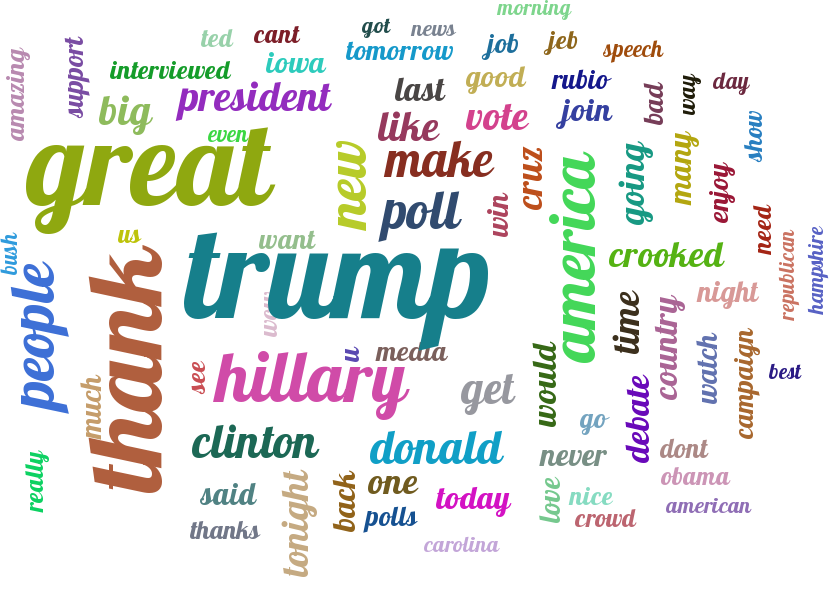

In [22]:
#For Trump: Make word clouds based on most frequent words

counts = fdist_t.most_common(80)
tags = make_tags(counts, maxsize=120)
wordcloud_trump = create_tag_image(tags, 'freq_cloud_trump.png', size=(900, 600), fontname='Lobster');

Image('freq_cloud_trump.png')

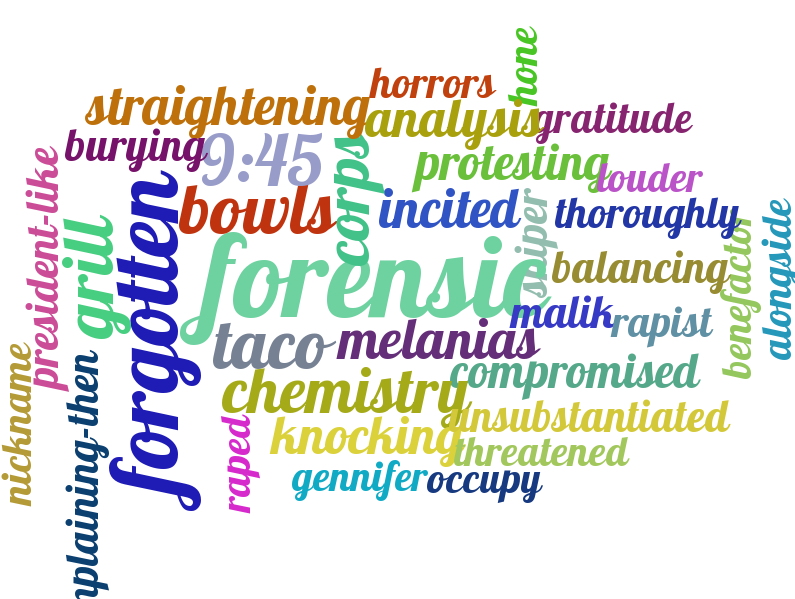

In [23]:
#For Trump: Make word cloud based on most reacted to words
mostReacted_trump = pd.DataFrame(list(trump_rxnfreq.items())[0:35])
counts = [tuple(x) for x in mostReacted_trump.values]
tags = make_tags(counts, maxsize=90)
wordcloud_trump = create_tag_image(tags, 'react_cloud_trump.png', size=(900, 600), fontname='Lobster');

Image('react_cloud_trump.png')

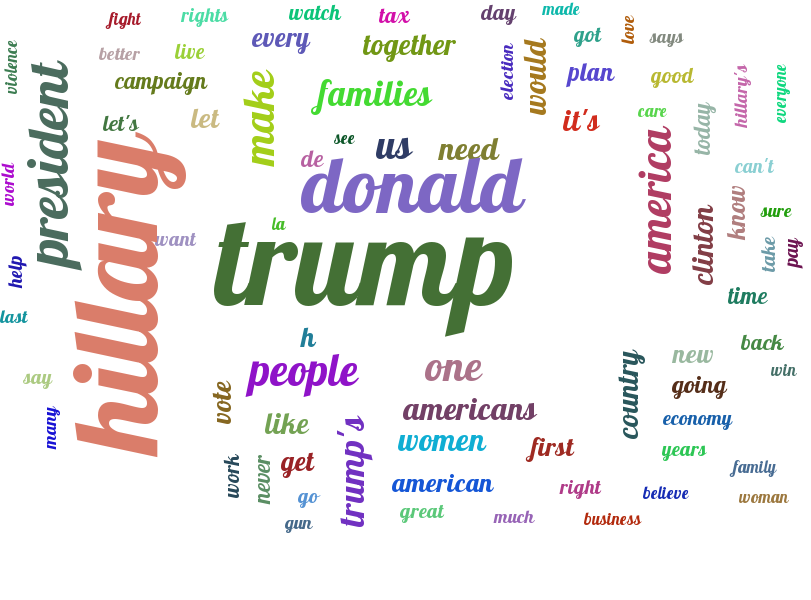

In [24]:
#For Hillary: Make word cloud based on most frequent used words
counts = fdist_h.most_common(80);
tags = make_tags(counts, maxsize=120)
wordcloud_trump = create_tag_image(tags, 'freq_cloud_hillary.png', size=(900, 600), fontname='Lobster');

Image('freq_cloud_hillary.png')

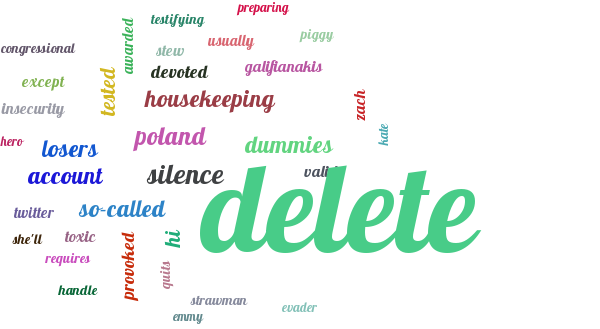

In [25]:
#For Hillary: Make word cloud based on most reacted to words
mostReacted_hillary = pd.DataFrame(list(hillary_rxnfreq.items())[0:35])
counts = [tuple(x) for x in mostReacted_hillary.values]
tags = make_tags(counts, maxsize=120)
wordcloud_trump = create_tag_image(tags, 'react_cloud_hillary.png', size=(600, 500), fontname='Lobster');

Image('react_cloud_hillary.png')

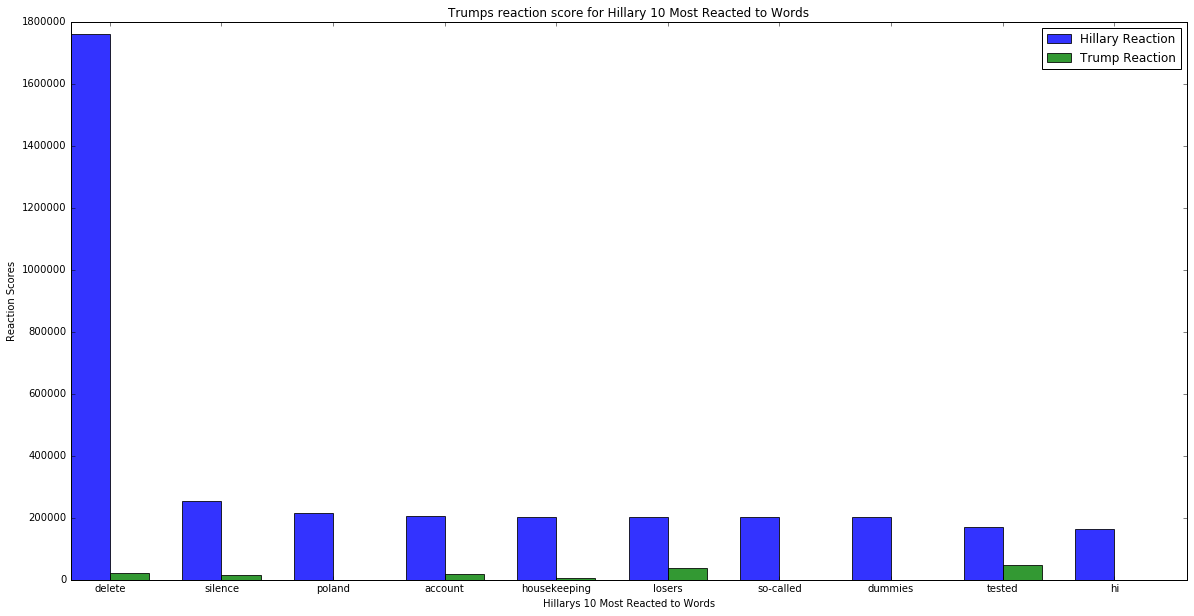

In [26]:
#Make bar graph for comparing hillary's most reacted words, compared to the reaction when trump uses them

h_t_rxn = {}
mostReacted_hillary = pd.DataFrame(list(hillary_rxnfreq.items())[0:10]);
for k, v in list(hillary_rxnfreq.items())[0:10]:
    #Lookup word in trump's dictiionary and store result in a new dictionary
    trump_reaction = trump_rxnfreq.get(k,0)
    h_t_rxn.setdefault(k, trump_reaction)
    
matching_trump = pd.DataFrame(list(h_t_rxn.items())[0:10]);

n_groups=10

plt.figure(figsize=(20,10))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, list(mostReacted_hillary[1]), bar_width,
                 alpha=opacity,
                 color='b',
                 label='Hillary Reaction')
 
rects2 = plt.bar(index + bar_width, matching_trump[1], bar_width,
                 alpha=opacity,
                 color='g',
                 label='Trump Reaction')
 
plt.xlabel('Hillarys 10 Most Reacted to Words')
plt.ylabel('Reaction Scores')
plt.title('Trumps reaction score for Hillary 10 Most Reacted to Words')
plt.xticks(index + bar_width, list(mostReacted_hillary[0]))
plt.legend()
 
#plt.tight_layout()
plt.show()

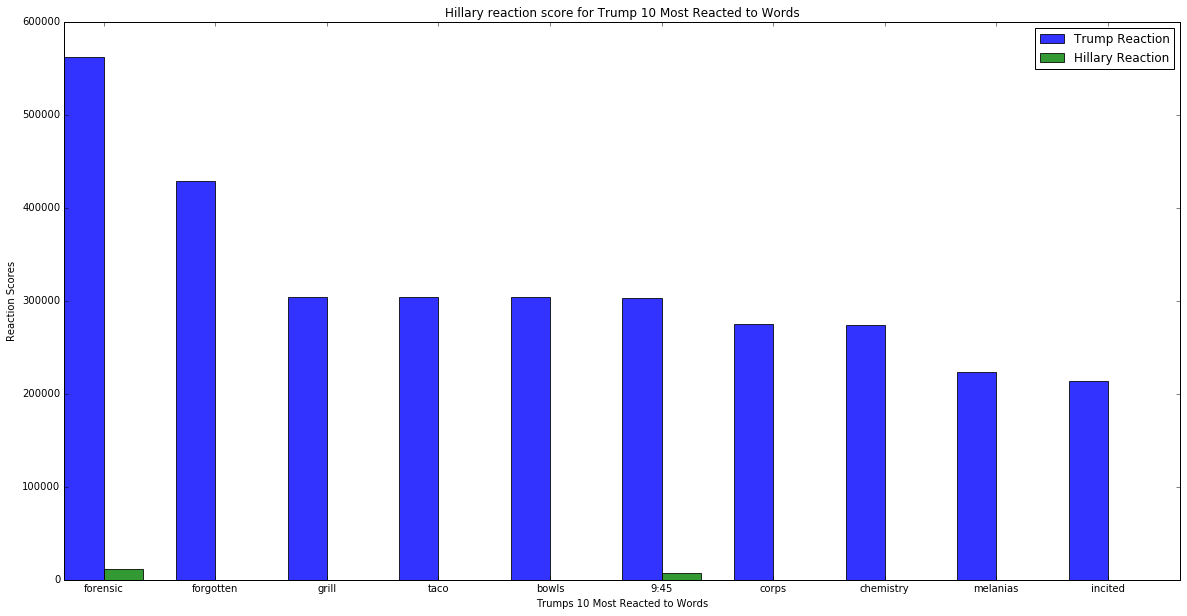

In [28]:
#Make bar graph for comparing trump's most reacted words, compared to the reaction when trump uses them

t_h_rxn = {}
mostReacted_trump = pd.DataFrame(list(trump_rxnfreq.items())[0:10]);
for k, v in list(trump_rxnfreq.items())[0:10]:
    #Lookup word in trump's dictiionary and store result in a new dictionary
    hillary_reaction = hillary_rxnfreq.get(k,0)
    t_h_rxn.setdefault(k, hillary_reaction)
    
matching_hillary = pd.DataFrame(list(t_h_rxn.items())[0:10]);

n_groups=10

plt.figure(figsize=(20,10))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, list(mostReacted_trump[1]), bar_width,
                 alpha=opacity,
                 color='b',
                 label='Trump Reaction')
 
rects2 = plt.bar(index + bar_width, matching_hillary[1], bar_width,
                 alpha=opacity,
                 color='g',
                 label='Hillary Reaction')
 
plt.xlabel('Trumps 10 Most Reacted to Words')
plt.ylabel('Reaction Scores')
plt.title('Hillary reaction score for Trump 10 Most Reacted to Words')
plt.xticks(index + bar_width, list(mostReacted_trump[0]))
plt.legend()
 
#plt.tight_layout()
plt.show()
